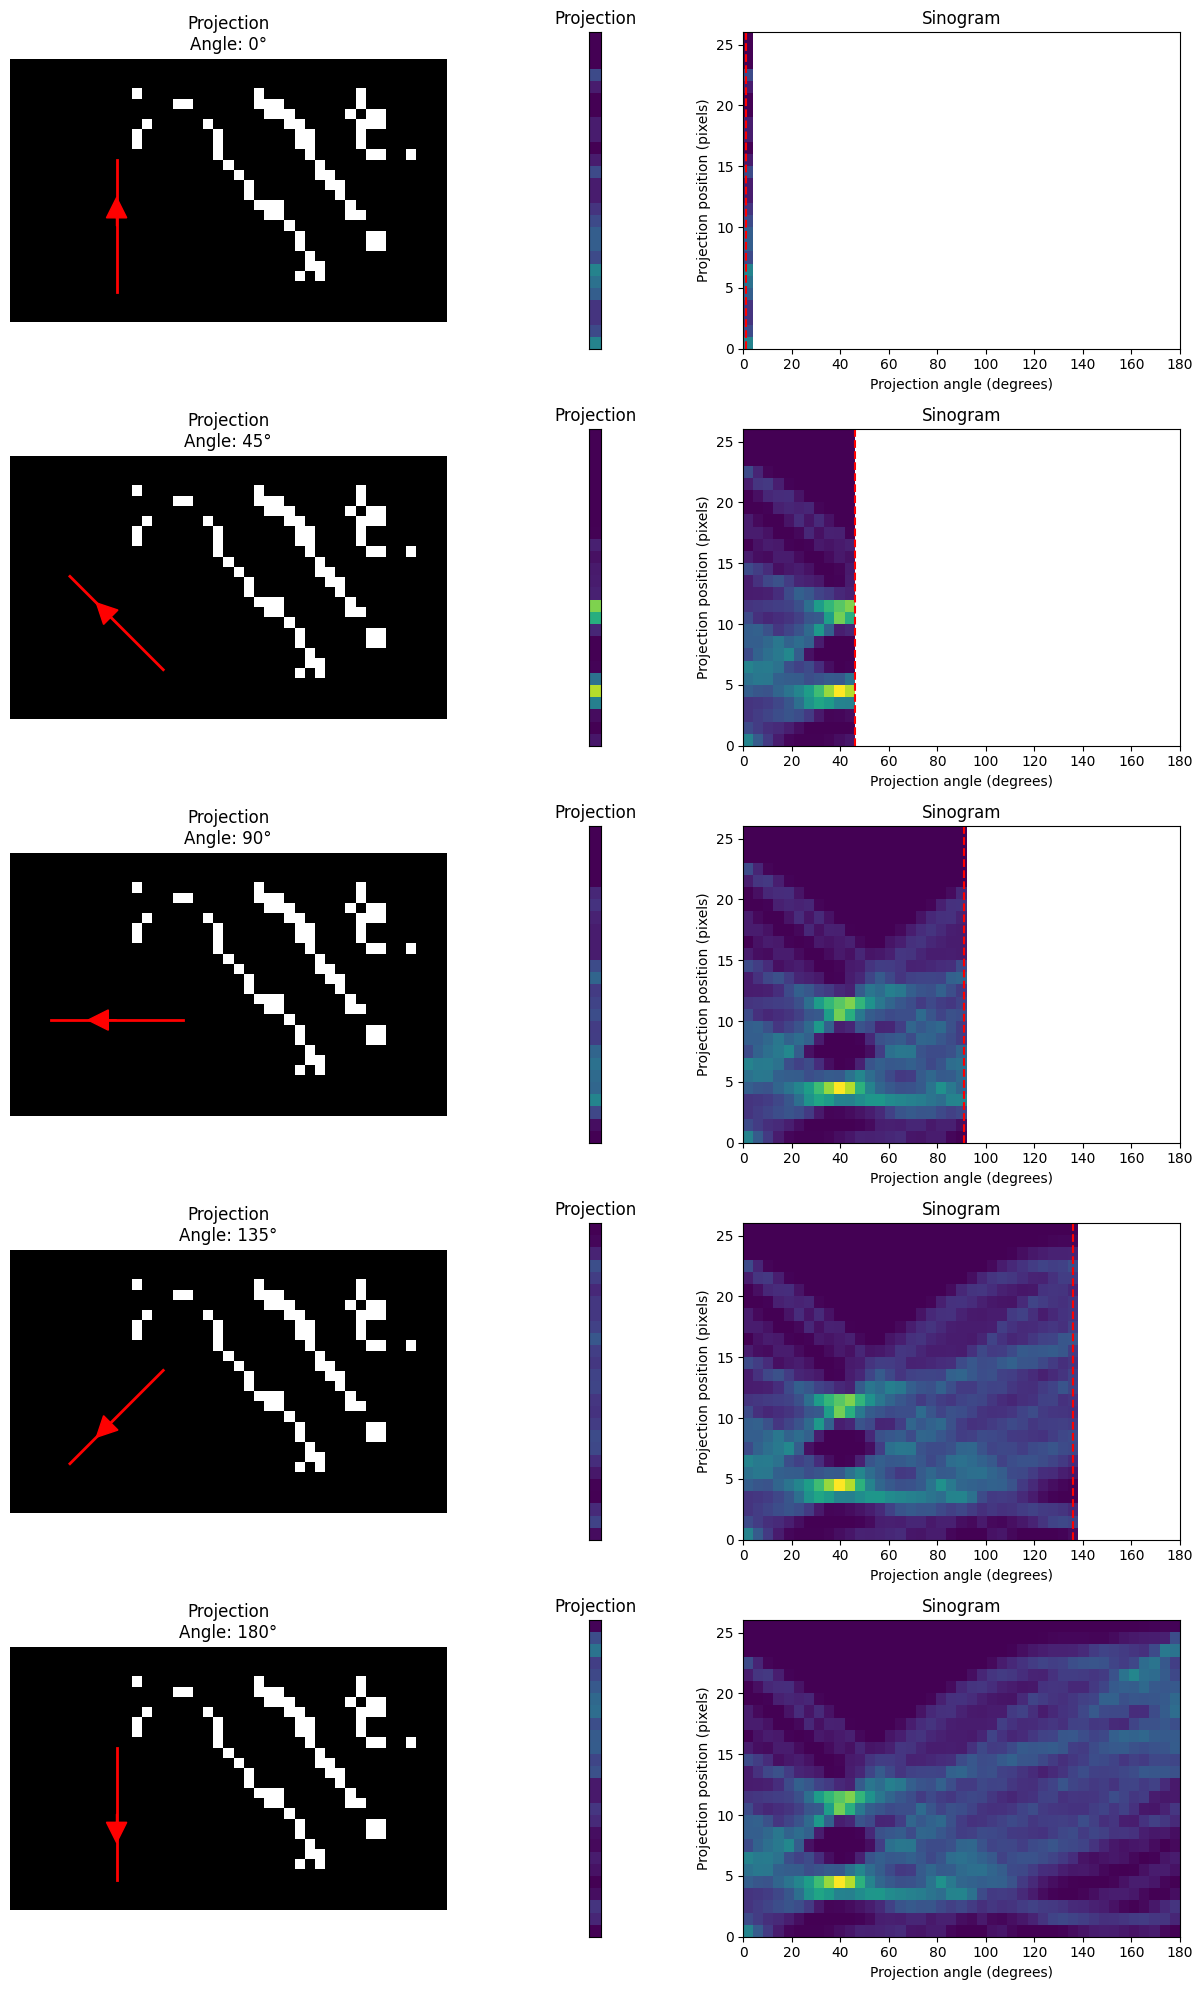

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
from PIL import Image
from scipy.ndimage import label, find_objects

def show_radon_projections(image_path, threshold=128, angles=[0, 45, 90, 135, 180]):
    # Load and threshold image
    image = Image.open(image_path).convert("L")
    img_array = np.array(image)
    binary_img = img_array > threshold

    # Remove white pixels touching the border
    labeled_array, num_features = label(binary_img)
    
    # Find slices for each labeled object
    objects_slices = find_objects(labeled_array)
    
    for i, slice_ in enumerate(objects_slices, start=1):
        # Check if the object touches any border
        y_slice, x_slice = slice_
        touches_top = y_slice.start == 0
        touches_bottom = y_slice.stop == binary_img.shape[0]
        touches_left = x_slice.start == 0
        touches_right = x_slice.stop == binary_img.shape[1]
        
        if touches_top or touches_bottom or touches_left or touches_right:
            # Remove this object from binary_img
            binary_img[labeled_array == i] = False

    # Define all angles for full sinogram
    theta = np.linspace(0., 180., max(img_array.shape), endpoint=False)
    sinogram = radon(binary_img, theta=theta, circle=True)

    fig, axs = plt.subplots(len(angles), 3, figsize=(12, 4 * len(angles)))
    
    for i, angle in enumerate(angles):
        # Plot original image with projection line
        ax_img = axs[i, 0]
        ax_img.imshow(binary_img, cmap='gray')
        ax_img.set_title(f'Projection\nAngle: {angle}°')
        ax_img.axis('off')

        # Draw projection line across the image
        size = binary_img.shape[0]/4
        center = (10, binary_img.shape[0]-10)
        length = size
        rad = np.deg2rad(angle+90)
        x0 = center[0] + length * np.cos(rad)
        y0 = center[1] - length * np.sin(rad)
        x1 = center[0] - length * np.cos(rad)
        y1 = center[1] + length * np.sin(rad)
        ax_img.plot([x0, x1], [y0, y1], 'r-', linewidth=2)

        # Add arrow at center pointing in the direction of the projection
        arrow_length = length / 8
        ax_img.arrow(center[0], center[1], 
                    arrow_length * np.cos(rad), 
                    -arrow_length * np.sin(rad), 
                    head_width=2, head_length=2, fc='red', ec='red')

        # Calculate projection for this angle from sinogram
        angle_idx = np.argmin(np.abs(theta - angle))

        # Find the global min and max intensity values in the sinogram
        vmin = sinogram.min()
        vmax = sinogram.max()

        # Plot the projection
        ax_proj = axs[i, 1]
        ind = int(np.floor((angle/180) * sinogram.shape[1]))
        ind = min(ind, sinogram.shape[1]-1)
        ax_proj.imshow(sinogram[:, ind:ind+1], vmin=vmin, vmax=vmax)
        ax_proj.set_title('Projection')
        ax_proj.set_xticks([])
        ax_proj.set_yticks([])
        ax_proj.set_xlabel('')
        ax_proj.set_ylabel('')

        ax_sino = axs[i, 2]

        # Compute index corresponding to current angle
        ind = int(np.floor((angle / 180) * sinogram.shape[1]))
        masked_sinogram = sinogram.copy()
        masked_sinogram[:, ind+1:] = np.nan

        # Plot full extent but with data only up to angle
        im = ax_sino.imshow(masked_sinogram, aspect='auto', extent=(0, 180, 0, sinogram.shape[0]), vmin=vmin, vmax=vmax)

        ax_sino.axvline(angle + 1, color='red', linestyle='--')
        ax_sino.set_title('Sinogram')
        ax_sino.set_xlabel('Projection angle (degrees)')
        ax_sino.set_ylabel('Projection position (pixels)')

        # Keep x-axis limits fixed to full range
        ax_sino.set_xlim(0, 180)

    plt.tight_layout()
    plt.savefig("src/readme_images/1 radon_projections_output.png", dpi=300)
    plt.show()

# Example usage
show_radon_projections("src/dataset/images/Grain 1.png")

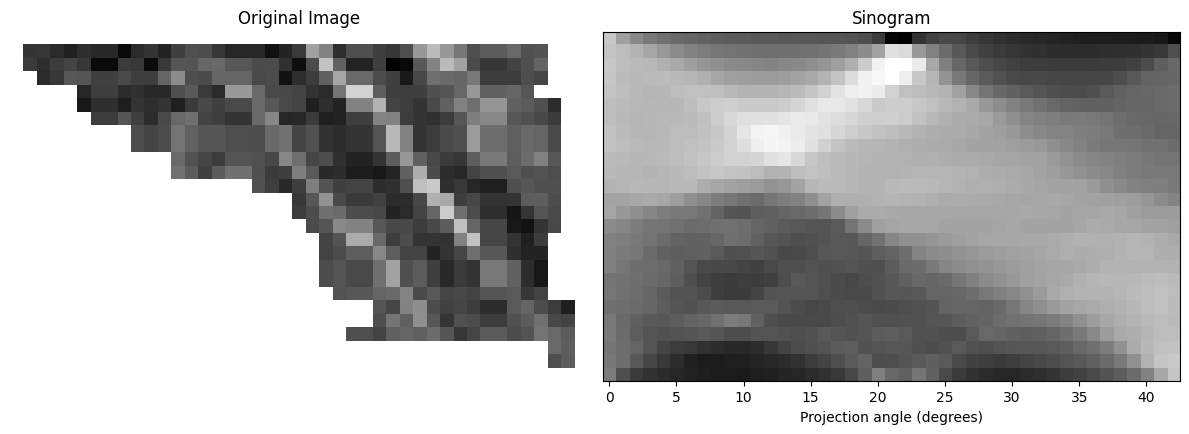

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
from PIL import Image

def process_image(image_path, threshold=128):
    # Load image
    image = Image.open(image_path).convert("L")
    
    # Convert to numpy array
    img_array = np.array(image)

    # Compute Radon transform
    theta = np.linspace(0., 180., max(img_array.shape), endpoint=False)
    sinogram = radon(img_array, theta=theta, circle=True)
    
    plt.figure(figsize=(12, 4)) 

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Sinogram")
    plt.xlabel("Projection angle (degrees)")
    plt.imshow(sinogram, cmap='gray')
    plt.gca().set_yticks([])  
    plt.gca().set_yticklabels([])  

    plt.tight_layout()
    plt.savefig("src/readme_images/2 non_segmented_output.png", dpi=300) 
    plt.show()

# Example usage:
process_image("src/dataset/images/Grain 1.png")

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
from PIL import Image
from scipy.ndimage import label, find_objects    

def process_image_from_path(image_path, threshold=128):   
    # Load image
    image = Image.open(image_path).convert("L")

    # Convert to numpy array
    img_array = np.array(image)
    
    # Threshold segmentation (binary)
    binary_img = img_array > threshold
    
    # Remove white pixels touching the border
    labeled_array, num_features = label(binary_img)
    
    # Find slices for each labeled object
    objects_slices = find_objects(labeled_array)
    
    for i, slice_ in enumerate(objects_slices, start=1):
        # Check if the object touches any border
        # slice_ is a tuple like (slice(y1, y2), slice(x1, x2))
        y_slice, x_slice = slice_
        touches_top = y_slice.start == 0
        touches_bottom = y_slice.stop == binary_img.shape[0]
        touches_left = x_slice.start == 0
        touches_right = x_slice.stop == binary_img.shape[1]
        
        if touches_top or touches_bottom or touches_left or touches_right:
            # Remove this object from binary_img
            binary_img[labeled_array == i] = False

    # Compute Radon transform
    theta = np.linspace(0., 180., max(img_array.shape), endpoint=False)
    sinogram = radon(binary_img, theta=theta, circle=True)
    
    plt.figure(figsize=(12, 4))  

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("deeplabv3_resnet101 Segmented")
    plt.imshow(binary_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Radon Transform")
    plt.xlabel("Projection angle (degrees)")
    plt.imshow(sinogram, cmap='gray')
    plt.gca().set_yticks([]) 
    plt.gca().set_yticklabels([])

    plt.tight_layout()
    plt.savefig("src/readme_images/3 segmented_output.png", dpi=300)  # Save the figure as a PNG file
    plt.show()

c:\Users\William Pearson\Documents\Personal\Portfolio\RadonAngleFinder\RadonAngleFinder\.venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


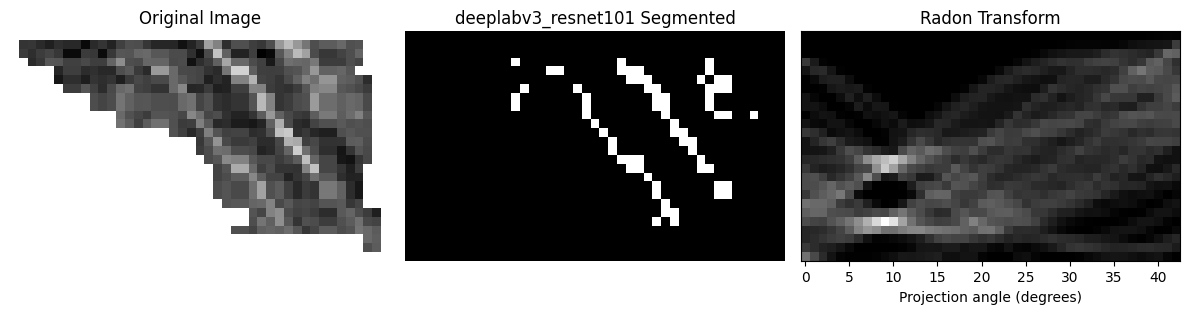

In [29]:
# Example usage:
process_image_from_path("src/dataset/images/Grain 1.png")

In [ ]:
def process_image(original_image, mask_image):
    mask_array = np.array(mask_image)

    # Compute Radon transform
    theta = np.linspace(0., 180., max(mask_array.shape), endpoint=False)
    sinogram = radon(mask_array, theta=theta, circle=True)
    
    plt.figure(figsize=(12, 4))  

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("deeplabv3_resnet101 Segmented")
    plt.imshow(mask_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Radon Transform")
    plt.xlabel("Projection angle (degrees)")
    plt.imshow(sinogram, cmap='gray')
    plt.gca().set_yticks([]) 
    plt.gca().set_yticklabels([])

    plt.tight_layout()
    plt.show()

c:\Users\William Pearson\Documents\Personal\Portfolio\RadonAngleFinder\RadonAngleFinder\.venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


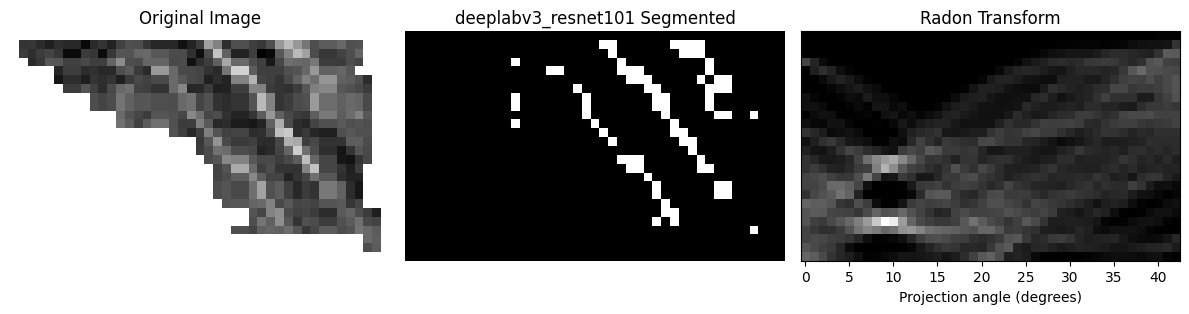

In [ ]:
image = Image.open("src/dataset/images/Grain 1.png").convert("L")
mask = Image.open("src/dataset/masks/Grain 1.png").convert("L")

process_image(image, mask)